Define function to search images on duckduckgo and return urls.

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=200):
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

Download images from different card games for use in training.

In [2]:
from fastcore.all import *
from fastai.vision.all import *
from time import sleep

searches = ['yugioh', 'pokemon', 'magic the gathering']
path = Path('identify')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} cards', max_images=200))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Remove broken images.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

52

Split up training/validation set and load data into block that can be read by model.

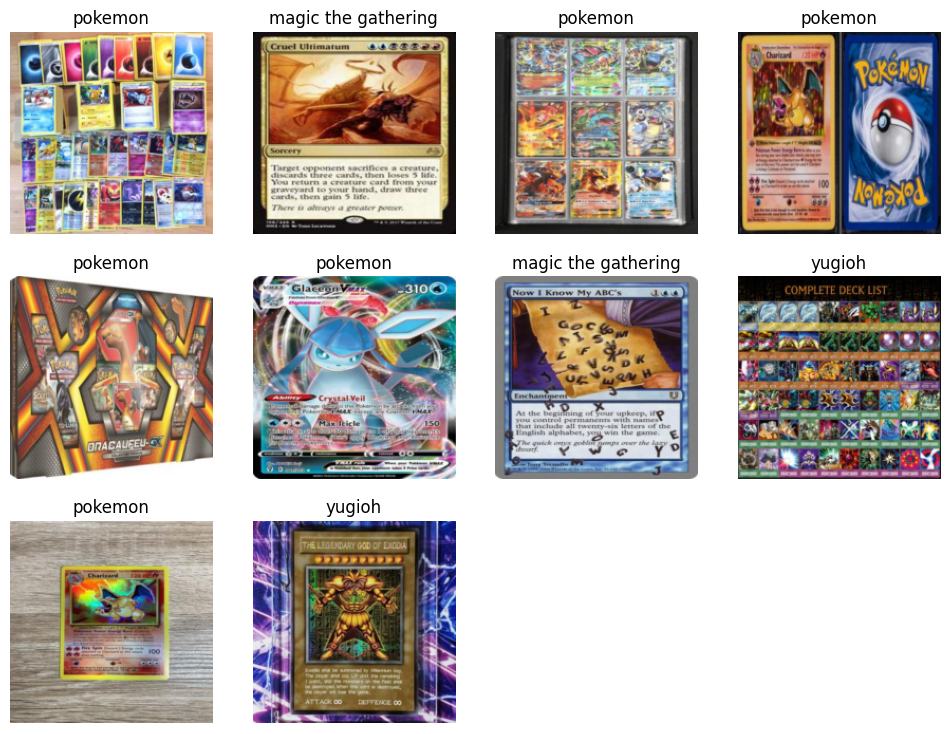

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=10)

Fine-tune resnet34 with data.

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch     train_loss  valid_loss  error_rate  time    
0         1.560293    0.994469    0.355769    01:56                                    
epoch     train_loss  valid_loss  error_rate  time    
0         0.505483    0.659975    0.240385    02:17                                     
1         0.350720    0.440554    0.201923    02:32                                     
2         0.259740    0.335247    0.144231    02:44                                     
3         0.187497    0.257620    0.105769    02:33                                     
4         0.147792    0.253353    0.096154    02:29                                     
5         0.116056    0.259743    0.086538    03:06                                     
6         0.094004    0.250223    0.096154    02:17                                     
7         0.077434    0.247640    0.096154    02:46                                     
8         0.064928    0.244426    0.086538    02:34                                     
9

Test out the model.

In [17]:
categories = ('Magic the Gathering', 'Pokemon',  'Yugioh')
def classify_image(img):
    img = PILImage.create(img)
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [19]:
examples = ['mtg.jpg', 'pokemon.jpg', 'yugioh.png', 'mtg_hard.jpg']
for ex in examples:
    print(classify_image(ex))

{'Magic the Gathering': 0.85282301902771, 'Pokemon': 0.010232929140329361, 'Yugioh': 0.1369440257549286}
{'Magic the Gathering': 0.00023495114874094725, 'Pokemon': 0.9978989362716675, 'Yugioh': 0.0018661428475752473}
{'Magic the Gathering': 5.0493108574301004e-05, 'Pokemon': 6.078515434637666e-05, 'Yugioh': 0.9998886585235596}


Test Gradio UI.

In [22]:
import gradio as gr

image = gr.components.Image(width=192, height=192)
label = gr.components.Label()

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Export the model.

In [6]:
learn.export('model.pkl')